In [1]:
#unzip file, create dir, store
import zipfile

!mkdir dataset
with zipfile.ZipFile("/content/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [2]:
import os
import shutil
import numpy as np

from matplotlib import pyplot as plt 

import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, Lambda, Dense, BatchNormalization, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam, Adagrad, SGD, RMSprop
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Set seed
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Global variables
BATCH_SIZE = 128
TARGET_SIZE=(224, 224)  # Resize input images to that size
INPUT_SHAPE = TARGET_SIZE + (3,)
NUM_CLASSES = 2  
DATA_PATH = '/content/dataset/'  # Root data path
TRAIN_PATH = os.path.join(DATA_PATH, 'train_data')  # Train data path 
VAL_PATH = os.path.join(DATA_PATH, 'test_data')  # Validation data path

In [4]:
TRAIN_PATH

'/content/dataset/train_data'

In [5]:
def classes_stat(image_iterator):
    """
    Function to print how many items per class has `image_iterator`.
    Returns dictionary `class_idx` to match class index to label
    """
    classes = image_iterator.classes
    class_idx = {v:k for k, v in image_iterator.class_indices.items()}
    for c in np.unique(classes):
        count = np.sum(classes==c)
        print('Class {} ({}): {} items'.format(c, class_idx[c], count))
    return class_idx

In [6]:
def image_plots(imgs, figsize=(12,8), rows=1, interp=False, titles=None):
    """
    Function to plot images from `imgs` array with optional labels from `titles`.
    Images will be plot in one figure with number of `rows`. 
    """
    f = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs) % 2 == 0 else len(imgs)//rows + 1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(imgs[i], interpolation=None if interp else 'none')

In [7]:
# Create image generator to read images from directory 
# and rescale pixel values from range [0; 255] to [0;1] 
image_gen = ImageDataGenerator(rescale=1.0/255)
train_iterator = image_gen.flow_from_directory(TRAIN_PATH, 
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE)

Found 910 images belonging to 2 classes.


In [8]:
# How many images per class?
_ = classes_stat(train_iterator)

Class 0 (TrainCP): 455 items
Class 1 (TrainNoise): 455 items


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


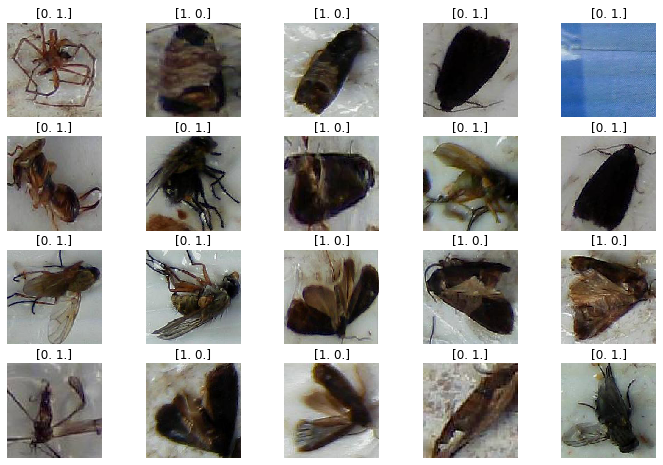

In [9]:
# Read batch of data
bx, by = next(train_iterator)

# Show images
image_plots(imgs=bx[:20], titles=by[:20], rows=4)

In [10]:

# Create image iterator
val_iterator = image_gen.flow_from_directory(VAL_PATH, 
                                            batch_size=1, 
                                            target_size=TARGET_SIZE, 
                                            shuffle=False)

Found 200 images belonging to 2 classes.


In [11]:
# How many images per class?
class_idx = classes_stat(val_iterator)

Class 0 (testcp): 100 items
Class 1 (testnoise): 100 items


In [12]:
def build_vgg_ft_model():
    # Prepare input for model with custom input shape
    input_tensor = Input(shape=INPUT_SHAPE)

    # Build model with pretrained weights and not top layers
    base_model = VGG16(input_shape=INPUT_SHAPE,
                           input_tensor=input_tensor,
                           weights='imagenet',
                           include_top=False)

    # Freeze layers so training will not change its weights
    for layer in base_model.layers: layer.trainable = False

    # Add dense output with num_classes
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5, name='drop')(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    pred_layer = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

    # Build model for provided classes
    model = Model(inputs=base_model.input, outputs=pred_layer)
    model.compile(optimizer=Adam(lr=1E-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model = build_vgg_ft_model()
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [14]:
# Train the model
val_steps = val_iterator.n 
r = model.fit_generator(train_iterator, 
                    steps_per_epoch=10, 
                    epochs=6, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)


Epoch 1/6
10/10 [==============================] - 25s 2s/step - loss: 0.7906 - accuracy: 0.6244 - val_loss: 1.1939 - val_accuracy: 0.5300
Epoch 2/6
10/10 [==============================] - 8s 759ms/step - loss: 0.4632 - accuracy: 0.7839 - val_loss: 1.1486 - val_accuracy: 0.5900
Epoch 3/6
10/10 [==============================] - 7s 721ms/step - loss: 0.3113 - accuracy: 0.8698 - val_loss: 0.9421 - val_accuracy: 0.6300
Epoch 4/6
10/10 [==============================] - 8s 777ms/step - loss: 0.2936 - accuracy: 0.8791 - val_loss: 0.7470 - val_accuracy: 0.6950
Epoch 5/6
10/10 [==============================] - 8s 782ms/step - loss: 0.2131 - accuracy: 0.9194 - val_loss: 0.5772 - val_accuracy: 0.6950
Epoch 6/6
10/10 [==============================] - 8s 794ms/step - loss: 0.1908 - accuracy: 0.9322 - val_loss: 0.5195 - val_accuracy: 0.6500


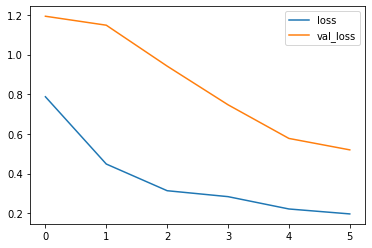

In [15]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

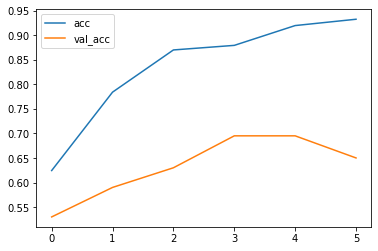

In [16]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [17]:
# Save weights and model
model.save_weights('./vgg16ft_weights.h5')

In [18]:
# Load saved weights
model.load_weights('./vgg16ft_weights.h5')

In [21]:
from PIL import Image, ImageOps

data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open('/content/1.jpg')

#resize the image to a 224x224 
#resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.ANTIALIAS)

#turn the image into a numpy array
image_array = np.asarray(image)

# display the resized image
image.show()

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
print(normalized_image_array.shape)
# Load the image into the array
data[0] = normalized_image_array

d = {}
with open("/content/labels.txt") as f:
    for line in f:
       (key, val) = line.split()
       d[int(key)] = val
 # run the inference
prediction = model.predict(data)


prediction = prediction*100


# print(prediction)

if(np.any(max(prediction[0]) == prediction[0][0])):
  print("The prediction is " + d[0]+"\nProbability is:  " + str(prediction[0][0]))
else:
  print("The prediction is " + d[1] + "\nProbability is:  " + str(prediction[0][1]))



(224, 224, 3)
The prediction is Moth
Probability is:  64.04161


In [22]:
# Predict labels for validation images
preds = model.predict_generator(val_iterator, val_steps, verbose=1)

200/200 [==============================] - 2s 11ms/step


In [23]:
# Convert predictions to classes and labels
classes = np.argmax(preds, axis=1)
labels = [class_idx[c] for c in classes]

In [24]:
# Save prediction results for each image to csv file 
results = list(zip(val_iterator.filenames, labels))

In [26]:
csv_fn = '/content/pred_results.csv'
np.savetxt(csv_fn, results, fmt='%s,%s')